In [1]:
from disk_utils_jax import jax_model, jax_model_scal
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np

## Defining Disk and SPF Parameters

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
disk_params2 = {}
disk_params2['inclination'] = 40. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [4]:
# Scattering Phase Function Parameters
spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

## Creating Disk Models

In [5]:
# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})
end = datetime.now()
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params2,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

2024-06-24 11:15:19.691670: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


0:00:04.362565
0:00:00.000716


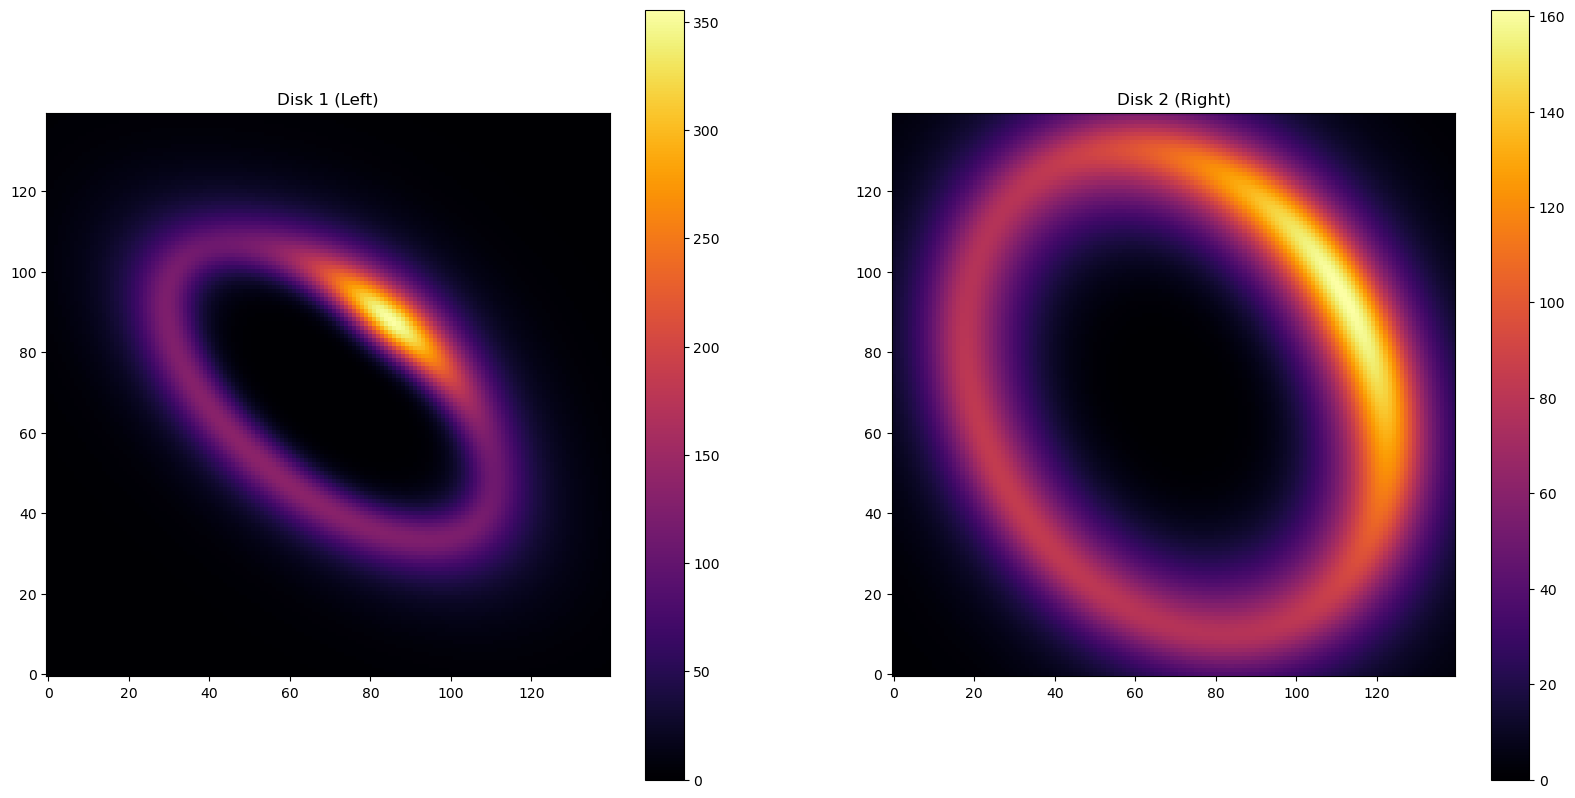

In [6]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0].set_title("Disk 1 (Left)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1].set_title("Disk 2 (Right)")
plt.colorbar(im,ax=axes[1])

## Timing Model Methods

In [7]:
def test():
    jax_model(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params=disk_params1)

%timeit test()

The slowest run took 11.34 times longer than the fastest. This could mean that an intermediate result is being cached.
265 µs ± 211 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
#def test():
#    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
#                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})

#%timeit test

## Add Noise

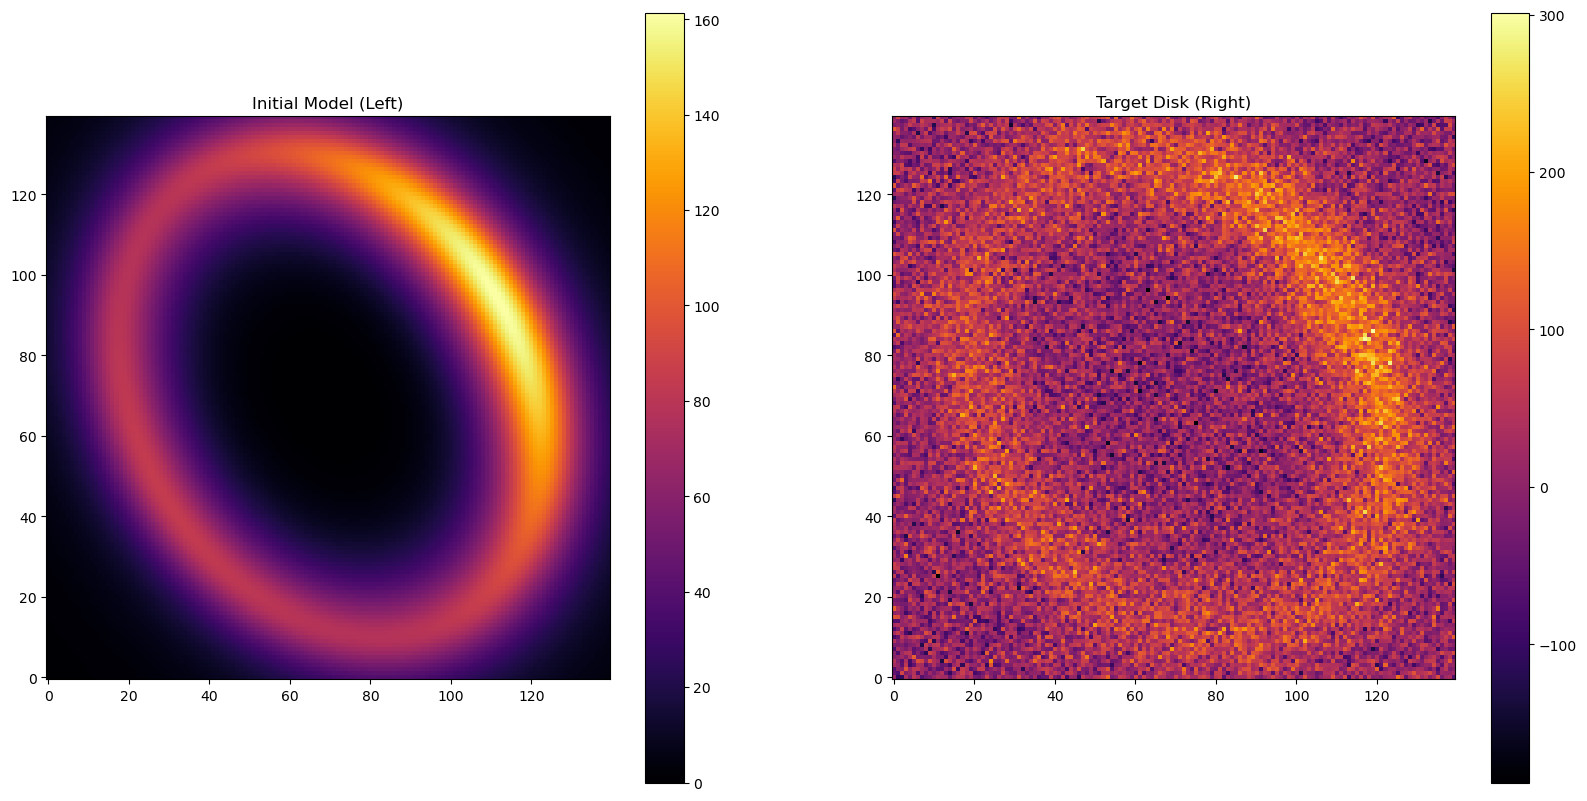

In [9]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0].set_title("Initial Model (Left)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk (Right)")
plt.colorbar(im,ax=axes[1])

## Testing Jax Grad with Disk Model Methods

In [10]:
#grad_func = jax.grad(jax_model_scal, argnums=(2, 3))
#print(grad_func(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params))

## Log-Likelihood Testing

In [11]:
ll2 = log_likelihood(DustEllipticalDistribution2PowerLaws,DoubleHenyeyGreenstein_SPF,disk_params2,spf_params,disk_image2+noise,
           np.ones(disk_image2.shape)*noise_level)
ll1 = log_likelihood(DustEllipticalDistribution2PowerLaws,DoubleHenyeyGreenstein_SPF,disk_params1,spf_params,disk_image2+noise,
           np.ones(disk_image2.shape)*noise_level)

print("Log-Likelihood of disk 2 model: {x}".format(x=ll2))
print("Log-Likelihood of disk 1 model: {x}".format(x=ll1))

Log-Likelihood of disk 2 model: -86512.8125
Log-Likelihood of disk 1 model: -134945.796875


## Testing Jax Grad with Log-Likelihood Method

In [12]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)

ll_grad_func = jax.grad(log_likelihood, argnums=(2,3))
print(ll_grad_func(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params, disk_image2+noise, np.ones(disk_image2.shape)*noise_level))

({'alpha_in': Array(2926.81051677, dtype=float64, weak_type=True), 'alpha_out': Array(-4393.33514895, dtype=float64, weak_type=True), 'flux_scaling': Array(-0.09173294, dtype=float64, weak_type=True), 'inclination': Array(-3602.85284052, dtype=float64, weak_type=True), 'position_angle': Array(79.07228351, dtype=float64, weak_type=True), 'sma': Array(4484.81535091, dtype=float64, weak_type=True)}, {'g1': Array(-31217.1124078, dtype=float64, weak_type=True), 'g2': Array(-6103.9335251, dtype=float64, weak_type=True), 'weight': Array(-48876.91095267, dtype=float64, weak_type=True)})


## Testing Scipy-Optimize Minimize with Log-Likelihood

In [13]:
import numpy as np

def convert_to_dict(disk_params, flux_scaling=1e6):
    disk_dict = {}
    disk_dict['inclination'] = disk_params[3]
    disk_dict['position_angle'] = disk_params[4]
    disk_dict['alpha_in'] = disk_params[0]
    disk_dict['alpha_out'] = disk_params[1]
    disk_dict['flux_scaling'] = flux_scaling
    disk_dict['sma'] = disk_params[2]
    return disk_dict

# using disk 1 params as initial parameters
disk_params_1d = np.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

In [14]:
# comparing disk 1 model to the disk 2 noise model
print(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level))

# comparing disk 2 model to the disk 2 noise model
print(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level))

134945.77815848147
86512.81566964462


In [15]:
# JIT compiling likelihood-1d method

log_likelihood_1d(disk_params_1d, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params, disk_params2["flux_scaling"],
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

def test():
    log_likelihood_1d(disk_params_1d, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params, disk_params2["flux_scaling"],
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)
%timeit test()

1.57 ms ± 301 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Optimizing Disk with Nelder-Mead Method (Doesn't Require Gradient)

In [16]:
from scipy.optimize import minimize
from jaxopt import ScipyMinimize
from jaxopt import ScipyBoundedMinimize

In [17]:
ll = lambda *args: -log_likelihood_1d(*args)
no_grad_method = "Nelder-Mead"

start = datetime.now()
soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method = no_grad_method)
end = datetime.now()
print(end-start)

disk_fit_nm = convert_to_dict(soln.x)

0:00:00.736765


### Optimizing Disk with Gradient

In [18]:

ll = lambda *args: -log_likelihood_1d(*args)

start = datetime.now()
soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method=None)
end = datetime.now()
print(end-start)

disk_fit_grad = convert_to_dict(soln.x)

0:00:00.495581


### Optimizing Disk with JAXopt

In [19]:
from regression import log_likelihood_1d_pos

# using a jax array instead of a numpy array
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

log_likelihood_1d_pos(disk_params_1d_jax, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params, disk_params2["flux_scaling"],
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

Array(134945.77815848, dtype=float64)

In [20]:
#llgf = lambda x: jax.grad(log_likelihood_1d_pos(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
#                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level), argnums=0)

ll = lambda x: log_likelihood_1d_pos(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

start = datetime.now()
solver = ScipyMinimize(fun=ll,  method="l-bfgs-b", maxiter=500, jit=False)
res = solver.run(init_params=disk_params_1d_jax)
#solver = ScipyBoundedMinimize(fun=ll, method="l-bfgs-b",maxiter=500,jit=False)
#res = solver.run(init_params=disk_params_1d_jax, bounds=([1, -10, 0, 0, 0], [10, -1, 80, 90, 90]))
end = datetime.now()
print(end-start)

params, states = res
print(params)

0:00:19.951898
[ 4.9700555  -7.30833468 40.29330762 40.33297391 29.52707263]


In [21]:
disk_fit_jaxopt = convert_to_dict(params)

## Displaying Scipy Fit Model Results

In [22]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_fit_nm, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Gradient Optimization Disk Parameters: " + str(disk_fit_grad))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_fit_grad, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("JAX Optimization Disk Parameters: " + str(disk_fit_jaxopt))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_fit_jaxopt, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 40.33297086997372, 'position_angle': 29.52690907323506, 'alpha_in': 4.969947330826463, 'alpha_out': -7.308540709790998, 'flux_scaling': 1000000.0, 'sma': 40.29349882984021}
Log-Likelihood: 86510.12136383806
Gradient Optimization Disk Parameters: {'inclination': 40.332921796789314, 'position_angle': 29.52696625849564, 'alpha_in': 4.969954858212346, 'alpha_out': -7.308530363437503, 'flux_scaling': 1000000.0, 'sma': 40.29347603222468}
Log-Likelihood: 86510.12136391737
JAX Optimization Disk Parameters: {'inclination': Array(40.33297391, dtype=float64), 'position_angle': Array(29.52707263, dtype=float64), 'alpha_in': Array(4.9700555, dtype=float64), 'alpha_out': Array(-7.30833468, dtype=float64), 'flux_scaling': 1000000.0, 'sma': Array(40.29330762, dtype=float64)}
Log-Likelihood: 86510.12136488731
Actual Disk Parameters: {'inclination': 40.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma'

In [23]:
start = datetime.now()
disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_nm,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
disk_image_fit_grad = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_grad,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
disk_image_fit_jaxopt = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_jaxopt,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

0:00:04.342729


Text(0.5, 1.0, 'Target Disk (Right)')

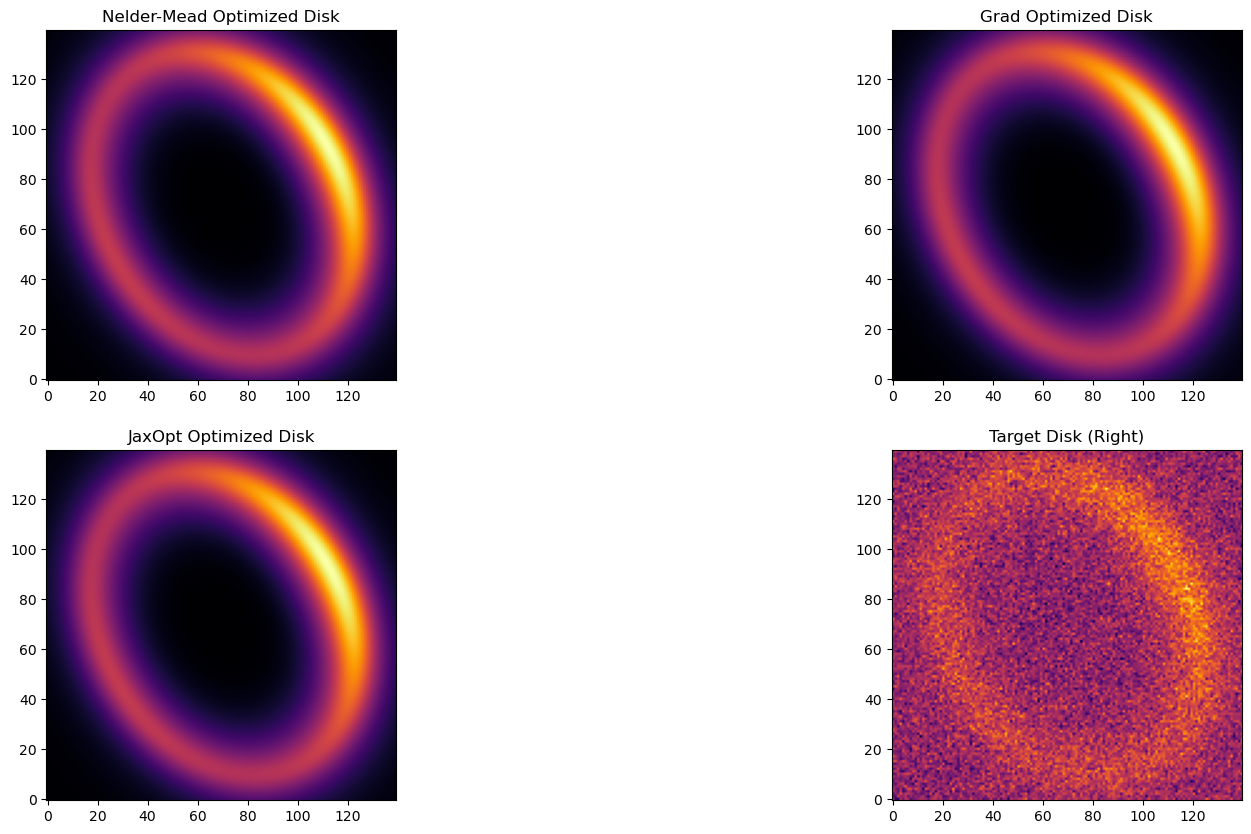

In [24]:
fig, axes = plt.subplots(2,2, figsize=(20,10))

axes[0][0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[0][0].set_title("Nelder-Mead Optimized Disk")

axes[0][1].imshow(disk_image_fit_grad, origin='lower', cmap='inferno')
axes[0][1].set_title("Grad Optimized Disk")

axes[1][0].imshow(disk_image_fit_jaxopt, origin='lower', cmap='inferno')
axes[1][0].set_title("JaxOpt Optimized Disk")

axes[1][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[1][1].set_title("Target Disk (Right)")

### More Precise Testing on Scipy Optimization Method Runtimes

In [25]:
ll = lambda *args: -log_likelihood_1d(*args)
llp = lambda x: log_likelihood_1d_pos(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

def nelder_mead_test():
    soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method="nelder-mead")
    
def gradient_optimization_test():
    soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method=None)
    
def jax_optimization_test():
    solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
    res = solver.run(init_params=disk_params_1d_jax)
    #solver = ScipyBoundedMinimize(fun=llp, method="l-bfgs-b",maxiter=500,jit=False)
    #res = solver.run(init_params=disk_params_1d_jax, bounds=([1, -10, 0, 0, 0], [10, -1, 80, 90, 90]))

In [26]:
%timeit nelder_mead_test()
%timeit gradient_optimization_test()
%timeit jax_optimization_test()

734 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
465 ms ± 5.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.32 s ± 3.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Running Optimizations with more Parameters

In [27]:
disk_params_1d_jax = jnp.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

# initial spf params, 0: g1, 1: g2, 2: weight
spf_params_jax = jnp.array([0.5, -0.5, 0.5])

all_pars = jnp.concatenate((disk_params_1d_jax, spf_params_jax))

In [28]:
from regression import log_likelihood_1d_pos_all_pars

# If nans are seen, Jax Opt won't work
llp = lambda x: log_likelihood_1d_pos_all_pars(x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

jax.config.update("jax_debug_nans", True)

grad_func = jax.grad(llp, argnums=(0))

print(grad_func(all_pars))

jax.config.update("jax_debug_nans", False)

[-2630.52060961  3825.8608104  -4050.78486445  3380.99394319
   -72.61463519  7164.78043598 -9237.39733363 -4223.090425  ]


In [29]:
no_grad_method = "Nelder-Mead"
soln_nm = minimize(llp, all_pars, method=no_grad_method)
disk_fit_nm = convert_to_dict(soln_nm.x)

soln_go = minimize(llp, all_pars, method = None)
disk_fit_go = convert_to_dict(soln_go.x)

#solver = ScipyBoundedMinimize(fun=llp, method="l-bfgs-b",maxiter=500,jit=False)
#soln_sm, ignore = solver.run(init_params=all_pars, bounds=([1, -10, 0, 0, 0, 0.05, -0.95, 0.05],
#                                                           [10, -1, 80, 90, 90, 0.95, -0.05, 0.95]))

solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
soln_sm, ignore = solver.run(init_params=all_pars)

### Likelihood Results

In [30]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_nm.x[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_nm.x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Gradient Optimization Disk Parameters: " + str(disk_fit_grad) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_go.x[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_go.x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("JAX Optimization Disk Parameters: " + str(disk_fit_jaxopt) + str(DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])))
print("Log-Likelihood: " + str(log_likelihood_1d_pos_all_pars(soln_sm, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Actual Disk Parameters: " + str(disk_params2) + str(spf_params))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))

Nelder-Mead Optimization Disk Parameters: {'inclination': 40.227380933796894, 'position_angle': 29.540529517176637, 'alpha_in': 4.953585765706352, 'alpha_out': -7.1859391343246894, 'flux_scaling': 1000000.0, 'sma': 40.205396136841216}{'g1': Array(0.49273556, dtype=float64), 'g2': Array(-0.36277628, dtype=float64), 'weight': Array(0.72296821, dtype=float64)}
Log-Likelihood: 86506.39446567654
Gradient Optimization Disk Parameters: {'inclination': 40.332921796789314, 'position_angle': 29.52696625849564, 'alpha_in': 4.969954858212346, 'alpha_out': -7.308530363437503, 'flux_scaling': 1000000.0, 'sma': 40.29347603222468}{'g1': Array(-0.27688608, dtype=float64), 'g2': Array(0.98814188, dtype=float64), 'weight': Array(0.24772605, dtype=float64)}
Log-Likelihood: 96474.76184600715
JAX Optimization Disk Parameters: {'inclination': Array(40.33297391, dtype=float64), 'position_angle': Array(29.52707263, dtype=float64), 'alpha_in': Array(4.9700555, dtype=float64), 'alpha_out': Array(-7.30833468, dty

### Image Comparisions

In [31]:
disk_fit_nm = convert_to_dict(soln_nm.x[0:5])
spf_params_nm = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_nm.x[5:])

disk_fit_go = convert_to_dict(soln_go.x[0:5])
spf_params_go = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_go.x[5:])

disk_fit_jaxopt = convert_to_dict(soln_sm[0:5])
spf_params_jaxopt = DoubleHenyeyGreenstein_SPF.unpack_pars(soln_sm[5:])


sp = DoubleHenyeyGreenstein_SPF.unpack_pars(spf_params_jax)
disk_image1_ap = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1, spf_params=sp)

disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_nm,
                               spf_params=spf_params_nm)
disk_image_fit_go = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_go,
                               spf_params=spf_params_go)
disk_image_fit_jaxopt = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_jaxopt,
                               spf_params=spf_params_jaxopt)

Text(0.5, 1.0, 'JaxOpt Optimized Disk')

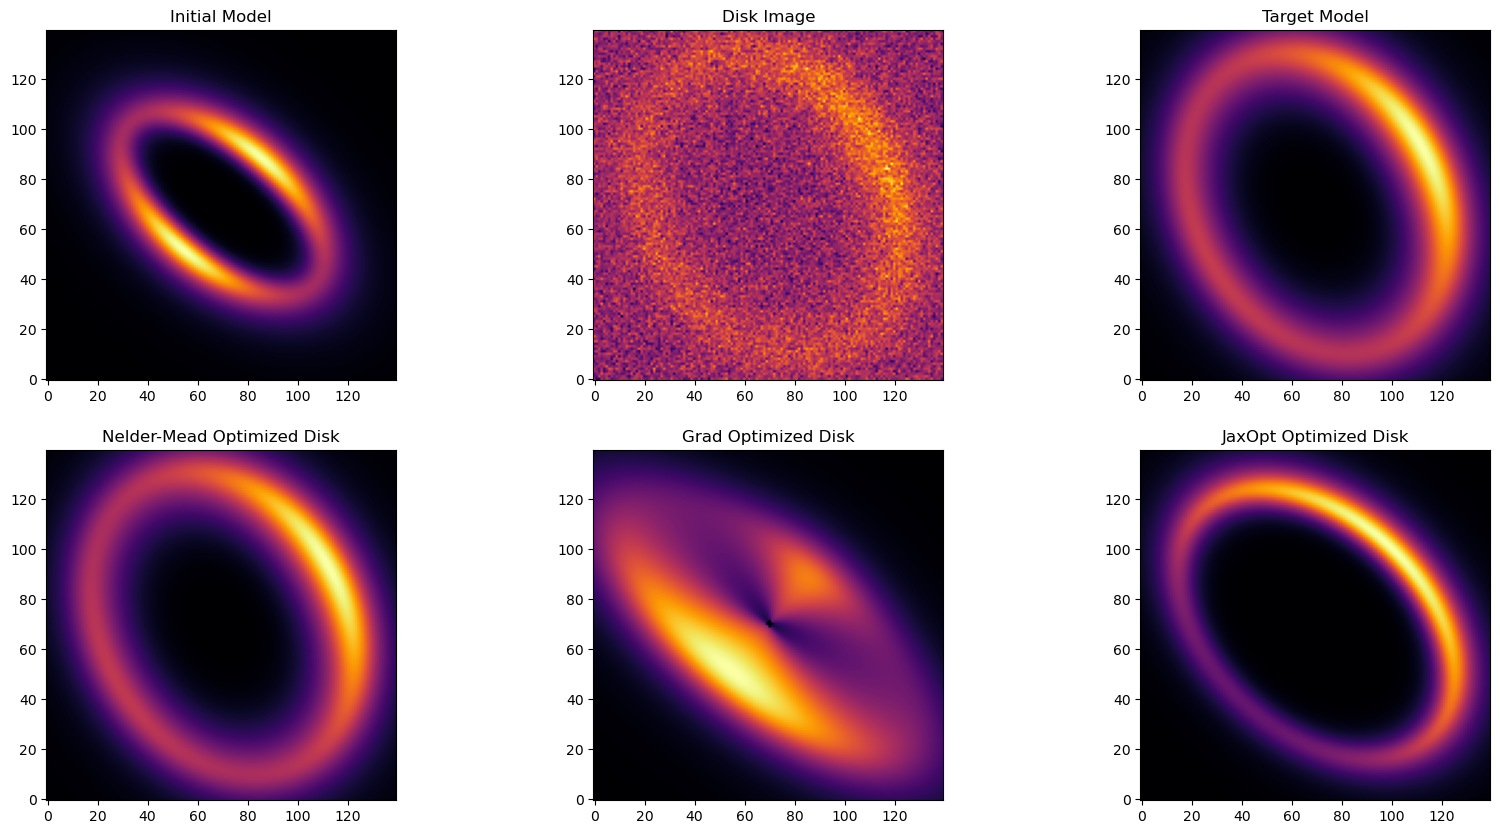

In [32]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

axes[0][0].imshow(disk_image1_ap, origin='lower', cmap='inferno')
axes[0][0].set_title("Initial Model")

axes[0][1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[0][1].set_title("Disk Image")

axes[0][2].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0][2].set_title("Target Model")

axes[1][0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[1][0].set_title("Nelder-Mead Optimized Disk")

axes[1][1].imshow(disk_image_fit_go, origin='lower', cmap='inferno')
axes[1][1].set_title("Grad Optimized Disk")

axes[1][2].imshow(disk_image_fit_jaxopt, origin='lower', cmap='inferno')
axes[1][2].set_title("JaxOpt Optimized Disk")

In [33]:
def nelder_mead_test():
    soln = minimize(llp, all_pars, method="Nelder-Mead")
    
def gradient_optimization_test():
    soln = minimize(llp, all_pars, method=None)
    
#def jax_optimization_test():
#    res = solver.run(init_params=all_pars, bounds=([1, -10, 0, 0, 0, 0.05, -0.95, 0.05],
#                                                    [10, -1, 80, 90, 90, 0.95, -0.05, 0.95]))
    
norm_solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
def jax_optimization_test_norm():
    res = norm_solver.run(init_params=all_pars)

#### Testing Runtimes

In [34]:
%timeit nelder_mead_test()
%timeit gradient_optimization_test()
#%timeit jax_optimization_test()
%timeit jax_optimization_test_norm()

3.76 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.05 s ± 9.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.01 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Plotting SPF vs Log-Likelihood

In [35]:
'''llspf1 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2['alpha_in'], disk_params2['alpha_out'], disk_params2['sma'], disk_params2['inclination'], 
                                                         disk_params2['position_angle'], x, -0.3, 0.7]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

llspf2 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2['alpha_in'], disk_params2['alpha_out'], disk_params2['sma'], disk_params2['inclination'], 
                                                         disk_params2['position_angle'], 0.5, x, 0.7]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

llspf3 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2['alpha_in'], disk_params2['alpha_out'], disk_params2['sma'], disk_params2['inclination'], 
                                                         disk_params2['position_angle'], 0.5, -0.3, x]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)

all_pars = jnp.concatenate((disk_params_1d_jax, spf_params_jax))

vals = np.linspace(-1, 1, 40)
results = np.zeros(40)

for i in range(0, len(vals)):
    results[i] = llspf1(vals[i])

plt.xlabel("g1")
plt.ylabel("positive log-likelihood")
plt.plot(vals, results)
plt.show()

for i in range(0, len(vals)):
    results[i] = llspf2(vals[i])

plt.xlabel("g2")
plt.ylabel("positive log-likelihood")
plt.plot(vals, results)
plt.show()

for i in range(0, len(vals)):
    results[i] = llspf3(vals[i])

plt.xlabel("weight")
plt.ylabel("positive log-likelihood")
plt.plot(vals, results)
plt.show()'''

'llspf1 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2[\'alpha_in\'], disk_params2[\'alpha_out\'], disk_params2[\'sma\'], disk_params2[\'inclination\'], \n                                                         disk_params2[\'position_angle\'], x, -0.3, 0.7]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,\n                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)\n\nllspf2 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2[\'alpha_in\'], disk_params2[\'alpha_out\'], disk_params2[\'sma\'], disk_params2[\'inclination\'], \n                                                         disk_params2[\'position_angle\'], 0.5, x, 0.7]), DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,\n                    disk_params2["flux_scaling"], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)\n\nllspf3 = lambda x: log_likelihood_1d_pos_all_pars(jnp.array([disk_params2[\'al

In [36]:
'''num_runs = 5

runs = np.arange(0, num_runs)

go_results = np.zeros(num_runs)
for i in range(0, num_runs):
    soln_go = minimize(llp, all_pars, method = None)
    go_results[i] = log_likelihood_1d_pos_all_pars(soln_go.x, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                        disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)
    
jo_results = np.zeros(num_runs)
solver = ScipyMinimize(fun=llp, method="l-bfgs-b", maxiter=500, jit=False)
for i in range(0, num_runs):
    soln_sm, ignore = solver.run(init_params=all_pars)
    jo_results[i] = log_likelihood_1d_pos_all_pars(soln_sm, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF,
                    disk_params2['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)'''

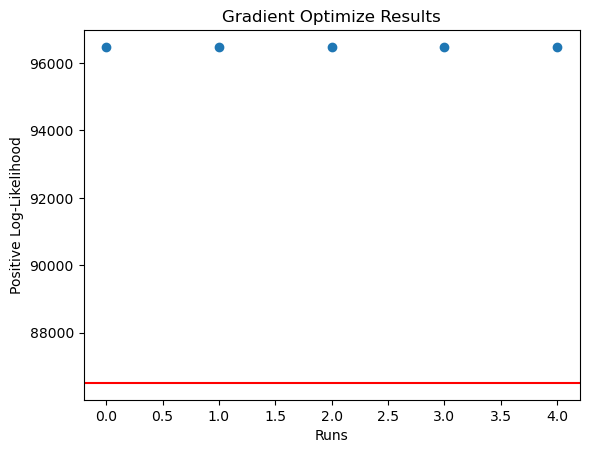

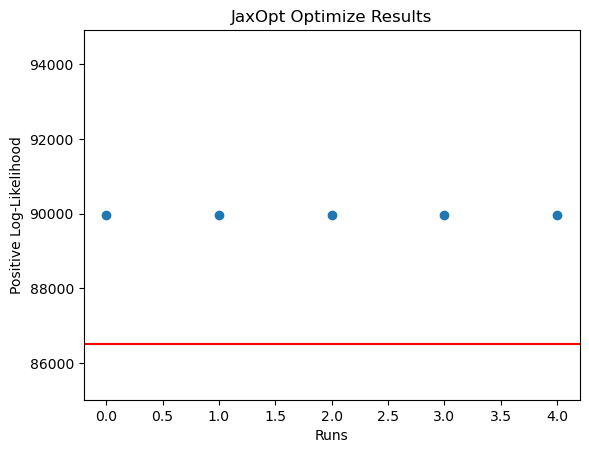

In [37]:
'''plt.scatter(runs, go_results)
plt.title("Gradient Optimize Results")
plt.xlabel("Runs")
plt.ylabel("Positive Log-Likelihood")
plt.axhline(y = -log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level), color = 'r', label = 'Target Log-Likelihood')
plt.show()

plt.scatter(runs, jo_results)
plt.title("JaxOpt Optimize Results")
plt.xlabel("Runs")
plt.ylabel("Positive Log-Likelihood")
plt.axhline(y = -log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level), color = 'r', label = 'Target Log-Likelihood')
plt.show()'''